In [25]:
# !pip install transformers torch numpy pandas scikit-learn underthesea

# **Import module**

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch, re, unicodedata, requests, time
from wordcloud import WordCloud
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
  accuracy_score,
  f1_score,
  classification_report,
  confusion_matrix,
  ConfusionMatrixDisplay
)
from underthesea import word_tokenize

Đặt style cho biểu đồ

In [27]:
sns.set_theme(style="whitegrid")

Kiểm tra GPU

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


Đọc file dataset

In [29]:
try:
    df_train = pd.read_json('archive/train-segment.json').T
    df_dev = pd.read_json('archive/dev-segment.json').T
    df_test = pd.read_json('archive/test-segment.json').T
    
    df_train.reset_index(drop=True, inplace=True)
    df_dev.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print(f"Đã tải xong!\nTrain size: {len(df_train)}\nValidation size: {len(df_dev)}\nTest size: {len(df_test)}")
    display(df_train.head(20))
except Exception as e:
    print(f"Lỗi đọc file: {e}")

Đã tải xong!
Train size: 24046
Validation size: 2672
Test size: 6680


,comment,label
0,em được làm fan cứng luôn rồi nè ❤ r...,clean
1,đúng là bọn mắt híp lò xo thụt : ) ) )...,hate
2,đậu văn cường giờ giống thằng sida...,clean
3,côn đồ cục súc vô nhân tính đề nghi ...,hate
4,từ lý thuyết đến thực hành là cả 1...,clean
5,coronavirus is manmade,clean
6,đố chúng m nhận ra ai,clean
7,lúp lúp như chó .,offensive
8,🥰 🥰 🥰,clean
9,"thế mà mình nói mấy thằng bắc kì ,...",hate


## Trực quan hóa dữ liệu

### Trước khi tiền xử lý

/tmp/ipykernel_35281/1314168148.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


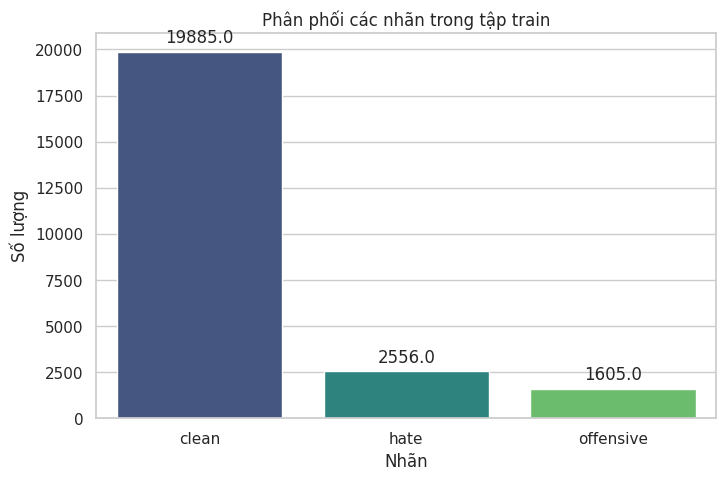

In [30]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df_train,
    x='label',
    palette='viridis'
)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Phân phối các nhãn trong tập train')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.show()

/tmp/ipykernel_35281/3416457373.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


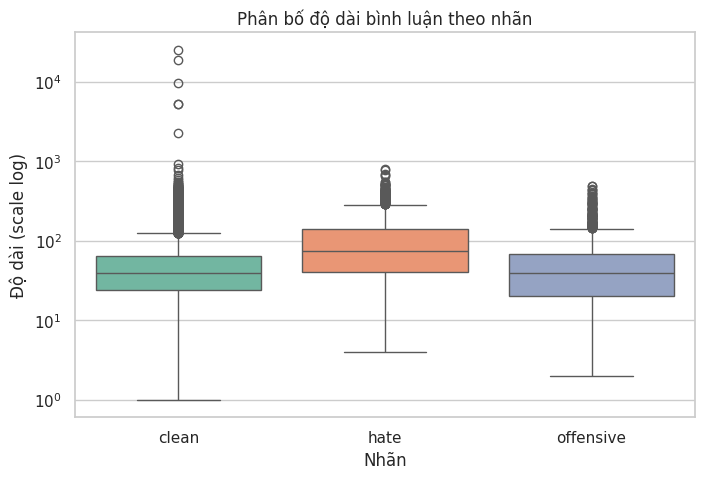

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    x='label',
    y=df_train['comment'].astype(str).apply(len),
    data=df_train,
    palette='Set2'
)

plt.title('Phân bố độ dài bình luận theo nhãn')
plt.yscale('log')
plt.xlabel('Nhãn')
plt.ylabel('Độ dài (scale log)')
plt.show()

### Pre-processing text

Thống nhất bảng mã

In [32]:
def normalize_unicode(text:str):
    return unicodedata.normalize('NFC', text)

Xử lý ký tự lặp

In [33]:
def remove_duplicate_characters(text:str):
    return re.sub(r'(.)\1+', r'\1', text)

Xử lý teencode

In [34]:
def normalize_teencode(text:str):
    teencode_dict = {
        # --- 1. Nhóm Phủ định ---
        "ko": "không", "k": "không", "kh": "không", "hok": "không", "hk": "không", 
        "hong": "không", "hông": "không", "hem": "không", "hơm": "không",
        
        # --- 2. Nhóm Đồng ý / Khẳng định ---
        "dc": "được", "đc": "được", "dk": "được", "đk": "được", "duoc": "được",
        "r": "rồi", "roi": "rồi", "rui": "rồi", "rùi": "rồi", "roy": "rồi",
        "lun": "luôn", "lunk": "luôn",
        "uk": "ừ", "uh": "ừ", "uhm": "ừ", "um": "ừ", "oke": "ok",
        
        # --- 3. Nhóm Đại từ nhân xưng ---
        "t": "tao", "m": "mày", "mik": "mình", "mjk": "mình", "mk": "mình",
        "mn": "mọi người", "m.n": "mọi người",
        "ng": "người", "ngta": "người ta",
        "bn": "bạn", "b": "bạn",
        "e": "em", "cj": "chị", "chj": "chị", "a": "anh",
        "ck": "chồng", "vk": "vợ", "ox": "chồng", "bx": "vợ",
        "ad": "admin", "mem": "thành viên",
        "ny": "người yêu", "nyc": "người yêu cũ",
        "vnch": "Việt Nam Cộng hòa", "vn": "Việt Nam",
        
        # --- 4. Nhóm Hành động ---
        "bit": "biết", "bik": "biết", "bít": "biết",
        "thik": "thích", "thic": "thích",
        "iu": "yêu", "ju": "yêu",
        "ib": "nhắn tin", "nt": "nhắn tin", "inbox": "nhắn tin",
        "cmt": "bình luận", "rep": "trả lời",
        "add": "thêm", "share": "chia sẻ",
        "ik": "đi",
        
        # --- 5. Nhóm Từ nối / Trạng từ / Hư từ ---
        "ấy": "đấy", "nhưg": "nhưng",
        "v": "vậy", "z": "vậy", "zậy": "vậy",
        "vs": "với", 's': 'sao',
        "j": "gì", "ji": "gì",
        "bh": "bây giờ", "h": "giờ",
        "wa": "quá", "qa": "quá", "qá": "quá", "wá": "quá",
        "thui": "thôi",
        "nx": "nữa",
        "nek": "nè", "ne": "nè",
        "ak": "à", "ah": "à",
        "cx": "cũng",
        "ms": "mới", 'ưi': 'ơi',
        "tr": "trời", "trùi": "trời",
        
        # --- 6. Nhóm Mạng xã hội & Slang ---
        "gato": "ghen tị",
        "klq": "không liên quan",
        "stt": "trạng thái", "avt": "ảnh đại diện", "fb": "facebook",
        "fa": "độc thân",
        "thuong": "thương",
        
        # --- 7. Nhóm Cảm thán mạnh / Chửi thề (Quan trọng cho Sentiment) ---
        "vl": "vãi lồn", "vcl": "vãi cả lồn", "vkl": "vãi cả lồn", "vc": "vãi cứt",
        "dell": "đéo", "đell": "đéo", "éo": "đéo", "đ": "đéo",
        "cmn": "con mẹ nó", "cmnr": "con mẹ nó rồi", "cc": "con cặc",
        "clm": "cái lồn mẹ",
        "dm": "địt mẹ", "đm": "địt mẹ", "dkm": "địt con mẹ", "đkm": "địt con mẹ",
        "loz": "lồn", "lz": "lồn", "cl": "cái lồn", "sml": "sấp mặt lồn"
    }

    words = text.split()
    normalized_words = [teencode_dict.get(word.lower(), word) for word in words]
    return " ".join(normalized_words)

Xử lý emoji

In [35]:
def normalize_emoticons(text:str):
    emo_dict = {
        # --- 1. Nhóm Tích cực / Vui vẻ / Yêu thích ---
        "🙂": "vui", "☺": "vui", "😀": "vui", "😁": "cười", "😃": "cười", "😄": "cười", "😅": "cười", 
        "😆": "cười", "😂": "cười", "🤣": "cười", "😹": "cười", "😺": "cười", "😸": "cười",
        "😇": "thiên thần", "😉": "nháy mắt", "😌": "nhẹ nhõm", "🥰": "yêu", "😍": "yêu", 
        "😘": "hôn", "😗": "hôn", "😙": "hôn", "😚": "hôn", "💋": "hôn", "👄": "miệng",
        "😋": "ngon", "😛": "le lưỡi", "😝": "le lưỡi", "😜": "trêu", "🤪": "điên",
        "🤩": "tuyệt vời", "🥳": "ăn mừng", "🤗": "ôm", "🙌": "hoan hô", "👏": "vỗ tay", "🤝": "bắt tay",
        "👍": "thích", "👌": "ổn", "✌": "vui", "🤞": "may mắn", "🤘": "ngầu", "🤟": "yêu", "🤙": "alo",
        "💪": "khỏe", "🙏": "cầu nguyện", "🌻": "hoa", "🌹": "hoa", "🌷": "hoa", "💐": "hoa", "🌺": "hoa", "🌼": "hoa",
        "❤": "yêu", "🧡": "yêu", "💛": "yêu", "💚": "yêu", "💙": "yêu", "💜": "yêu", "🖤": "yêu", "♥": "yêu",
        "💗": "yêu", "💓": "tim đập", "💖": "yêu", "💕": "yêu", "💞": "yêu", "💝": "quà",
        "🎉": "pháo hoa", "🎊": "pháo hoa", "🎆": "pháo hoa", "🏆": "cúp", "🎁": "quà", "🎀": "nơ",
        "💯": "tuyệt đối", "✅": "đúng", "✔": "đúng", "☑": "đúng",
        "😎": "ngầu", "🤓": "mọt sách",
        
        # --- 2. Nhóm Tiêu cực / Buồn / Tức giận ---
        "☹": "buồn", "🙁": "buồn", "😟": "lo lắng", "😕": "bối rối", "😔": "buồn", "😞": "thất vọng", 
        "😣": "đau", "😖": "đau", "😫": "mệt", "😩": "than vãn", "🥺": "cầu xin", "😢": "khóc", 
        "😭": "khóc", "😿": "khóc", "😤": "hừ", "😠": "tức", "😡": "giận", "🤬": "chửi", 
        "🤯": "nổ não", "😳": "sốc", "🥵": "nóng", "🥶": "lạnh", "😱": "sợ", "😨": "sợ", "😰": "lo", 
        "😥": "toát mồ hôi", "😓": "toát mồ hôi", "🤗": "ôm", "🤔": "suy nghĩ", "🤭": "che miệng", 
        "🤫": "im lặng", "🤥": "nói dối", "😶": "cạn lời", "😐": "cạn lời", "😑": "cạn lời", 
        "🙄": "khinh", "😯": "ngạc nhiên", "😦": "ngạc nhiên", "😧": "sốc", "😮": "ngạc nhiên", 
        "😲": "ngạc nhiên", "🥱": "buồn ngủ", "😴": "ngủ", "🤤": "thèm", "😪": "buồn ngủ", 
        "😵": "chóng mặt", "🤐": "im lặng", "🥴": "say", "🤢": "buồn nôn", "🤮": "nôn", 
        "🤧": "hắt hơi", "😷": "đeo khẩu trang", "🤒": "ốm", "🤕": "bị thương",
        "👎": "tệ", "👊": "đấm", "🖕": "chửi", "👇": "dưới", "👆": "trên", "👈": "trái", "👉": "phải",
        "🖐": "tay", "✋": "tay", "👋": "vẫy tay", "🤷": "không biết", "🤦": "thất vọng", "🙅": "không",
        "💔": "đau lòng", "🥀": "hoa héo", "💀": "chết", "☠": "độc", "👻": "ma", "💩": "cứt", "🤡": "hề", 
        "👿": "quỷ", "😈": "ác", "👹": "quỷ", "👺": "quỷ",
        "💣": "bom", "🔪": "dao", "🗡": "dao", "⚔": "kiếm", "🔫": "súng", "🩸": "máu", "💊": "thuốc",
        
        # --- 3. Nhóm Động vật (Thường dùng để chửi hoặc khen) ---
        "🐶": "chó", "🐕": "chó", "🦮": "chó", "🐩": "chó",
        "🐱": "mèo", "🐈": "mèo", "😹": "mèo cười", "😻": "mèo yêu", "😾": "mèo giận", "😽": "mèo hôn", "🙀": "mèo sốc",
        "🐷": "lợn", "🐖": "lợn", "🐽": "lợn", "🐗": "lợn",
        "🐮": "bò", "🐂": "bò", "🐄": "bò", "🐃": "trâu",
        "🐔": "gà", "🐓": "gà", "🐥": "gà", "🐤": "gà",
        "🐵": "khỉ", "🐒": "khỉ", "🙉": "không nghe", "🙊": "không nói", "🙈": "không nhìn",
        "🐸": "ếch", "🐍": "rắn", "🐲": "rồng", "🐉": "rồng",
        "🦄": "kỳ lân", "🐴": "ngựa", "🐎": "ngựa",
        "🐧": "chim cánh cụt", "🐦": "chim", "🦅": "đại bàng", "🦉": "cú",
        "🦇": "dơi", "🦋": "bướm", "🐝": "ong", "🐞": "bọ", "🐜": "kiến", "🦟": "muỗi",
        "🐡": "cá", "🐠": "cá", "🐟": "cá", "🐬": "cá heo", "🐳": "cá voi", "🦈": "cá mập",
        "🐙": "bạch tuộc", "🦀": "cua", "🦞": "tôm", "🦐": "tôm",
        
        # --- 4. Nhóm Đồ vật & Biểu tượng khác ---
        "🔥": "cháy", "⚡": "sét", "✨": "lấp lánh", "🌟": "ngôi sao", "⭐": "ngôi sao", "🌙": "trăng", "🌚": "mặt đen", 
        "☀": "nắng", "☁": "mây", "🌈": "cầu vồng", "🌊": "sóng", "💧": "nước", "💦": "nước",
        "🍅": "cà chua", "🍆": "cà tím", "🌽": "ngô", "🍄": "nấm",
        "🍌": "chuối", "🍏": "táo", "🍎": "táo", "🍐": "lê", "🍊": "cam", "🍋": "chanh", 
        "🍉": "dưa hấu", "🍇": "nho", "🍓": "dâu", "🍈": "dưa", "🍒": "cherry", "🍑": "đào", 
        "🍍": "dứa", "🥥": "dừa", "🥝": "kiwi", "🥑": "bơ", 
        "🍔": "bánh mì", "🍟": "khoai tây", "🍕": "pizza", "🌭": "xúc xích", "🥪": "bánh mì", 
        "🌮": "bánh", "🌯": "bánh", "🍜": "mì", "🍝": "mì", "🍚": "cơm", "🍛": "cơm", 
        "🍱": "cơm", "🍣": "sushi", "🍢": "xiên", "🍡": "bánh", "🍤": "tôm", 
        "🍦": "kem", "🍧": "kem", "🍨": "kem", "🍩": "bánh", "🍪": "bánh", "🎂": "bánh", 
        "🍰": "bánh", "🧁": "bánh", "🥧": "bánh", "🍫": "socola", "🍬": "kẹo", "🍭": "kẹo", 
        "🍺": "bia", "🍻": "bia", "🍷": "rượu", "🍹": "nước", "🍸": "rượu", 
        "☕": "cà phê", "🍵": "trà", "🍼": "sữa", 
        "⚽": "bóng đá", "🏀": "bóng rổ", "🏈": "bóng bầu dục", "⚾": "bóng chày", "🎾": "quần vợt", 
        "🏐": "bóng chuyền", "🏉": "bóng bầu dục", "🎱": "bida", "🏓": "bóng bàn", "🏸": "cầu lông", 
        "🥅": "khung thành", "🥊": "đấm bốc", "🥋": "võ", 
        "🎮": "game", "🕹": "game", "🎰": "game", 
        "🚗": "xe", "🚕": "taxi", "🚙": "xe", "🚌": "xe buýt", "🚎": "xe điện", 
        "🏎": "xe đua", "🚓": "cảnh sát", "🚑": "cứu thương", "🚒": "cứu hỏa", "🚐": "xe", 
        "🚚": "xe tải", "🚛": "xe tải", "🚜": "máy cày", "🏍": "xe máy", "🛵": "xe máy", 
        "🚲": "xe đạp", "🛴": "xe đẩy", 
        "🚀": "tên lửa", "✈": "máy bay", "🛩": "máy bay", "🚁": "trực thăng", 
        "🏦": "ngân hàng", "🏧": "atm", "💰": "tiền", "💵": "tiền", "💸": "tiền", 
        "💎": "kim cương", "💍": "nhẫn", 
        "🚬": "thuốc lá", "⚰": "quan tài", "⚱": "bình tro", 
        "👀": "nhìn", "👁": "mắt", "🧠": "não", 
        "👶": "em bé", "🤰": "có bầu", 
        "👮": "cảnh sát", "👷": "công nhân", "💂": "lính", "🕵": "thám tử", 
        "👵": "bà", "👴": "ông", "👳": "người ấn", "👲": "người trung", 
        "👸": "công chúa", "🤴": "hoàng tử", 
        "👫": "cặp đôi", "💑": "cặp đôi", "💏": "hôn", 
        "👭": "bạn bè", "👬": "bạn bè", "💃": "nhảy", "🕺": "nhảy",
        "🔞": "18 cộng", "🚭": "cấm thuốc", 
        "🧱": "gạch", "📌": "ghim", "📢": "loa", "🔊": "loa"
    }
    
    words = text.split()
    normalized_words = [emo_dict.get(word.lower(), word) for word in words]
    return " ".join(normalized_words)

Xử lý icon regex

In [36]:
def normalize_emoticons_regex(text):
    patterns = {
        r"[:=8]\s*[-o^]?\s*[)\]}]+(?:\s*[)\]}]+)*": " vui ",
        r"[:=8]\s*[-o^]?\s*[dD]+(?:\s*[dD]+)*": " cười ",
        r"[\^]\s*[-_]?\s*[\^]": " vui ", # Bắt ^^, ^_^
        r"[:=8]\s*[-o^]?\s*[vV]+(?:\s*[vV]+)*": " cười ",
        r"[:=8]\s*[-o^]?\s*[3]+(?:\s*[3]+)*": " cười ",
        r"[:=8]\s*[-o^]?\s*[oO0]+(?:\s*[oO0]+)*": " ngạc nhiên ",
        r"[:=8]\s*[-o^]?\s*[pP]+(?:\s*[pP]+)*": " đùa ",
        r"[:=8]\s*[-o^]?\s*[']?\s*[(<{]+(?:\s*[(<{]+)*": " buồn ",
        r"-\s*[-_.]\s*-": " chán "
    }
    
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    return text

In [37]:
def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = normalize_unicode(text)
    text = normalize_teencode(text)
    text = remove_duplicate_characters(text)
    text = normalize_emoticons_regex(text)
    text = normalize_emoticons(text)
    text = word_tokenize(text.lower(), format="text") 
    return text

Áp dụng các biện pháp xử lý

In [38]:
tqdm.pandas(desc="Đang làm sạch dữ liệu")
df_train['comment_processed'] = df_train['comment'].apply(preprocess_text)
df_dev['comment_processed'] = df_dev['comment'].apply(preprocess_text)
df_test['comment_processed'] = df_test['comment'].apply(preprocess_text)

X_train_raw = df_train['comment_processed'].tolist()
y_train = df_train['label'].tolist()
X_dev_raw = df_dev['comment_processed'].tolist()
y_dev = df_dev['label'].tolist()
X_test_raw = df_test['comment_processed'].tolist()
y_test = df_test['label'].tolist()

print("Xử lý xong.")
print("Dữ liệu sau khi xử lý:")
print(df_train['comment_processed'].head(20))

Xử lý xong.
Dữ liệu sau khi xử lý:
0     em được làm fan cứng luôn rồi nè yêu reaction ...
1     đúng là bọn mắt híp lò_xo thụt vui bên việt_na...
2              đậu văn_cường giờ giống thằng sida hơn à
3     côn_đồ cục súc vô_nhân_tính đề_nghi việt_nam ....
4     từ lý_thuyết đến thực_hành là cả 1 câu_chuyện ...
5                                coronavirus is manmade
6                               đố chúng_mày nhận ra ai
7                                     lúp lúp như chó .
8                                           yêu yêu yêu
9     thế mà mình nói mấy thằng bắc_kì , bọn đó lại ...
10    được anh ơi , lâu rồi không nghe phúc_du_rap cười
11          cắt cho trẻ trâu bớt thôi mà cười_cười_cười
12              nghe rất vô_lí nhưng cực_kì thuyết_phục
13           chán ghê không có pé 2 mới máu được , hâha
14                                 sao tao gửi được bây
15    thế đấy . làm gì bọn nó . bọn nó có quyền nên ...
16             loại này cho dựa cột thôi chứ độ thế_nào
17           

Word Cloud - Stop words để trực quan hóa

Label: clean


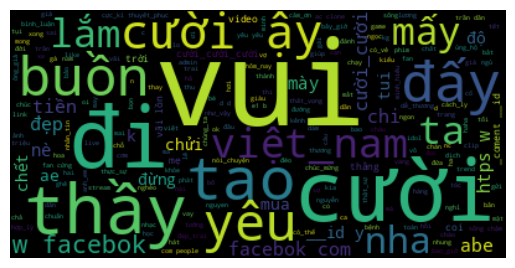

<Figure size 640x480 with 0 Axes>

Label: hate


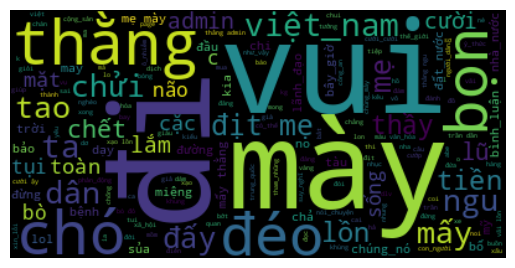

<Figure size 640x480 with 0 Axes>

Label: offensive


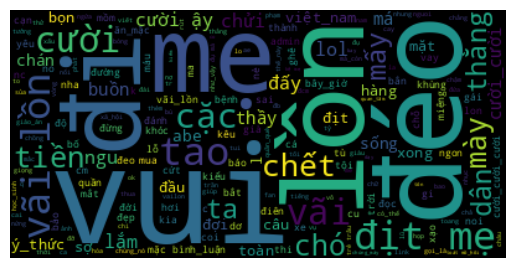

<Figure size 640x480 with 0 Axes>

In [39]:
url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
stopwords = requests.get(url).text.splitlines()

def getWordCloud(words):
    text = ' '.join(words)
    wordcloud = WordCloud(stopwords=stopwords).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    plt.figure()
    plt.show()

labels = ['clean', 'hate', 'offensive']

for label in labels:
    word_list = []
    for senc in df_train[df_train['label'] == label]['comment_processed']:
        # Combine words in each sentence into a single string.
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)
        
    print(f"Label: {label}")
    getWordCloud(word_list)

### Label Encoding

In [40]:
le_label = LabelEncoder()
y_train = le_label.fit_transform(y_train)
y_dev = le_label.fit_transform(y_dev)
y_test = le_label.transform(y_test)

## PhoBERT

In [41]:
print("Đang tải PhoBERT...")
phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

phobert.to(device)
print("Đã tải xong PhoBERT!")

Đang tải PhoBERT...
Đã tải xong PhoBERT!


Vector hóa

In [42]:
def get_embeddings(sentences, batch_size=32):
    """
    Chuyển đổi danh sách văn bản thành vector bằng PhoBERT
    """
    all_embeddings = []
    
    # Chia nhỏ dữ liệu thành các batch để không bị tràn RAM
    for i in tqdm(range(0, len(sentences), batch_size), desc="Embedding"):
        batch_texts = sentences[i : i+batch_size]
        
        # 1. Tokenize: Chuyển chữ thành số
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)
        
        
        # 2. Đưa vào mô hình PhoBERT
        with torch.no_grad():
            outputs = phobert(**inputs)
            
        # 3. Lấy vector đặc trưng
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(embeddings)
        
    # Nối các batch lại thành một mảng lớn
    return np.vstack(all_embeddings)

# Bắt đầu chuyển đổi
print("Đang vector hóa tập Train...")
X_train_bert = get_embeddings(X_train_raw)

print("Đang vector hóa tập Valid...")
X_dev_bert = get_embeddings(X_dev_raw)

print("Đang vector hóa tập Test...")
X_test_bert = get_embeddings(X_test_raw)

print(f"Kích thước tập Train mới: {X_train_bert.shape}")

Đang vector hóa tập Train...


Embedding: 100%|██████████| 752/752 [01:03<00:00, 11.87it/s]


Đang vector hóa tập Valid...


Embedding: 100%|██████████| 84/84 [00:06<00:00, 12.56it/s]


Đang vector hóa tập Test...


Embedding: 100%|██████████| 209/209 [00:19<00:00, 10.82it/s]

Kích thước tập Train mới: (24046, 768)


# **Training model**

In [43]:
models = {
    'logistic': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=2000,
        class_weight='balanced'
    ),
    
    'linear-svm': LinearSVC(
        class_weight='balanced',
        max_iter=3000,
        dual=True,
        random_state=42
    )
}

In [44]:
results = {}

for name, model in models.items():
    print(f"Đang huấn luyện mô hình: {name} ...")
    start_time = time.time()
    
    # Huấn luyện mô hình
    model.fit(X_train_bert, y_train)
    
    train_time = time.time() - start_time
    print(f"--> Đã xong! Thời gian: {train_time:.2f}s")
    
    results[name] = model

/home/gemini/.pyenv/versions/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Đang huấn luyện mô hình: logistic ...
--> Đã xong! Thời gian: 106.51s
Đang huấn luyện mô hình: linear-svm ...
--> Đã xong! Thời gian: 276.06s


/home/gemini/.pyenv/versions/ai-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evaluation

ĐÁNH GIÁ: logistic
Classification Report:
              precision    recall  f1-score   support

       clean       0.94      0.70      0.81      2190
        hate       0.34      0.61      0.43       270
   offensive       0.22      0.56      0.31       212

    accuracy                           0.68      2672
   macro avg       0.50      0.63      0.52      2672
weighted avg       0.82      0.68      0.73      2672



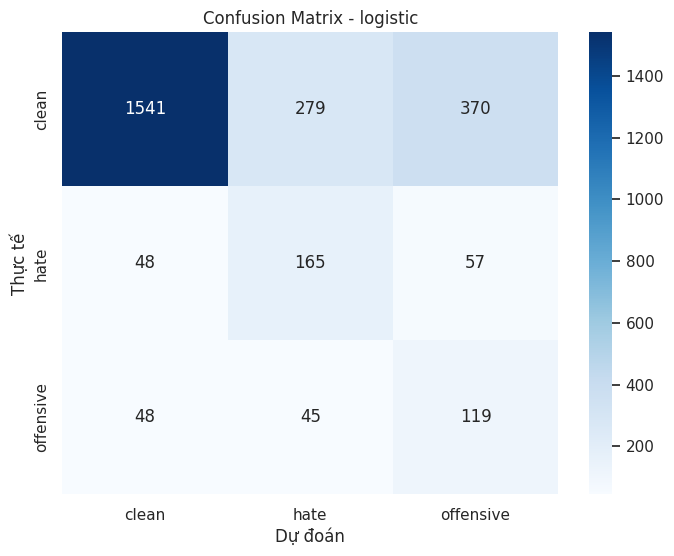

ĐÁNH GIÁ: linear-svm
Classification Report:
              precision    recall  f1-score   support

       clean       0.91      0.89      0.90      2190
        hate       0.48      0.54      0.51       270
   offensive       0.33      0.37      0.35       212

    accuracy                           0.81      2672
   macro avg       0.58      0.60      0.59      2672
weighted avg       0.82      0.81      0.82      2672



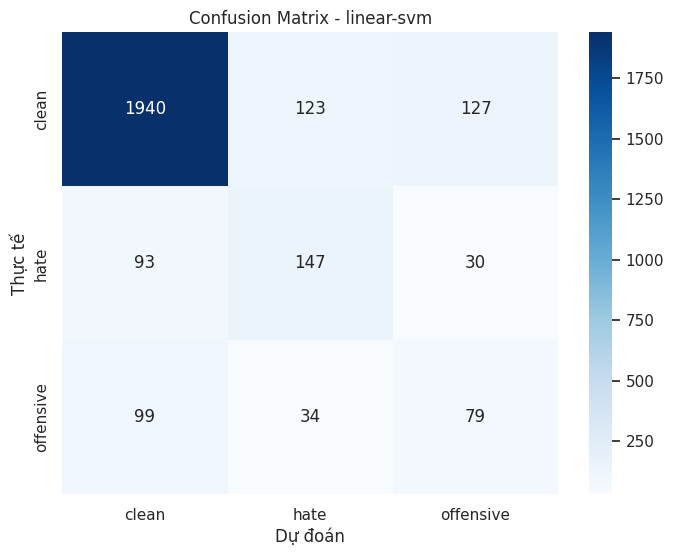

In [45]:
def evaluate_model(model_name, model, X_test, y_test, label_encoder):
    print(f"ĐÁNH GIÁ: {model_name}")
    
    # Dự đoán
    y_pred = model.predict(X_test)
    
    y_test_text = label_encoder.inverse_transform(y_test)
    y_pred_text = label_encoder.inverse_transform(y_pred)
    
    print("Classification Report:")
    print(classification_report(y_test_text, y_pred_text))
    
    cm = confusion_matrix(y_test_text, y_pred_text, labels=label_encoder.classes_)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.show()

for name, model in results.items():
    evaluate_model(name, model, X_dev_bert, y_dev, le_label)

In [ ]:
from sklearn.model_selection import GridSearchCV

print("ĐANG TÌM CẤU HÌNH TỐT NHẤT (GRID SEARCH)...")

# 1. Định nghĩa không gian các tham số cần thử
# C: Tham số quan trọng nhất của SVM (độ phạt lỗi). C càng lớn càng cố gắng không sai sót trên tập train (dễ overfit), C nhỏ thì lỏng tay hơn.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'class_weight': ['balanced', None], # Thử cả có và không có cân bằng dữ liệu
    'loss': ['hinge', 'squared_hinge'], # Các hàm mất mát khác nhau
    'dual': ['auto']
}

# 2. Khởi tạo mô hình gốc
base_model = LinearSVC(random_state=42, max_iter=5000)

# 3. Thiết lập bộ dò tìm (Grid Search)
# cv=5: Chia tập train thành 5 phần để kiểm tra chéo (Cross Validation) cho chắc ăn
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)

# 4. Bắt đầu chạy (Pha cà phê đợi xíu nhé!)
grid_search.fit(X_train_bert, y_train)

print(f"\n--> Cấu hình đỉnh nhất là: {grid_search.best_params_}")
print(f"--> F1-Score tốt nhất trên tập Train (CV): {grid_search.best_score_:.4f}")

# 5. Kiểm tra ngay trên tập Test xem có lên trình không
best_model = grid_search.best_estimator_
print(f"\nKẾT QUẢ SAU KHI TỐI ƯU TRÊN TẬP TEST:")
evaluate_model("Optimized LinearSVC", best_model, X_test_bert, y_test, le_label)

ĐANG TÌM CẤU HÌNH TỐT NHẤT (GRID SEARCH)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST VỚI linear-svm
ĐÁNH GIÁ: linear-svm
Classification Report:
              precision    recall  f1-score   support

       clean       0.91      0.88      0.89      5548
        hate       0.42      0.52      0.46       688
   offensive       0.27      0.30      0.28       444

    accuracy                           0.80      6680
   macro avg       0.53      0.57      0.55      6680
weighted avg       0.82      0.80      0.81      6680



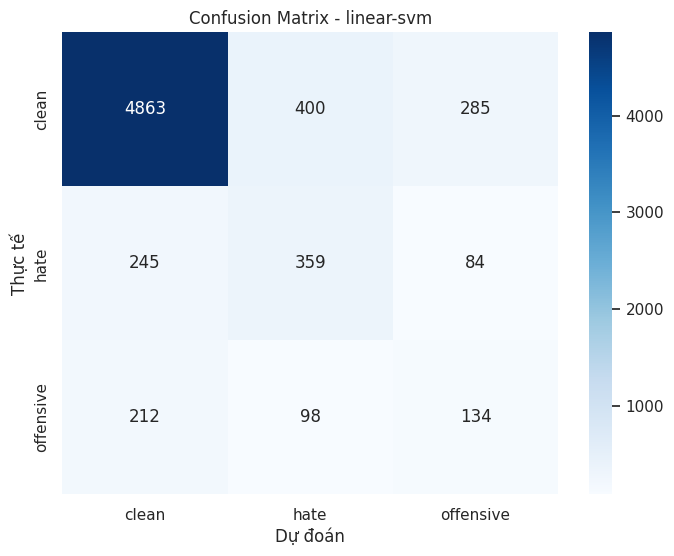

In [46]:
best_model_name = 'linear-svm' 
best_model = results[best_model_name]

print(f"KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST VỚI {best_model_name}")
evaluate_model(best_model_name, best_model, X_test_bert, y_test, le_label)